<a href="https://colab.research.google.com/github/CienciaDatosUdea/002_EstudiantesAprendizajeEstadistico/blob/main/semestre2025-2/Laboratorios/Laboratorio_07_nn_zeroV1_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# Libreias

import pandas as pd             # Manipulación y análisis de datos
import scipy as sc              # Herramientas científicas avanzadas
import numpy as np              # Cálculo numérico y matrices
import h5py                     # Lectura de archivos HDF5
import matplotlib.pylab as plt  # Generación de gráficos
import os                       # Manejo de archivos y carpetas
import requests                 # Descargar archivos de internet
import sympy as sp              # Cálculo simbólico

In [46]:
# Descargar los datasets desde múltiples espejos (mirrors) para mayor fiabilidad
# 1. Tu ruta base exacta
base_path = "/home/steven-sarmiento/002_EstudiantesAprendizajeEstadistico/semestre2025-2/Estudiantes/Sarmiento_8348/Labs/dataset/"

if not os.path.exists(base_path):
    os.makedirs(base_path)

# 2. Lista de espejos (Mirrors) para asegurar la descarga
mirrors_train = [
    "https://raw.githubusercontent.com/rvarun7777/Deep_Learning/master/Neural%20Networks%20and%20Deep%20Learning/Week%202/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/train_catvnoncat.h5",
    "https://raw.githubusercontent.com/JudasDie/deeplearning.ai/master/Neural%20Networks%20and%20Deep%20Learning/week4/datasets/train_catvnoncat.h5"
]

mirrors_test = [
    "https://raw.githubusercontent.com/rvarun7777/Deep_Learning/master/Neural%20Networks%20and%20Deep%20Learning/Week%202/Logistic%20Regression%20as%20a%20Neural%20Network/datasets/test_catvnoncat.h5",
    "https://raw.githubusercontent.com/JudasDie/deeplearning.ai/master/Neural%20Networks%20and%20Deep%20Learning/week4/datasets/test_catvnoncat.h5"
]

def download_with_mirrors(mirrors, filename):
    filepath = os.path.join(base_path, filename)
    
    # Limpiamos archivo previo si existe para evitar corruptos
    if os.path.exists(filepath):
        os.remove(filepath)
        
    print(f"Iniciando descarga de: {filename}")
    
    for url in mirrors:
        try:
            print(f" -> Intentando desde: ...{url[-30:]}")
            r = requests.get(url, allow_redirects=True)
            
            if r.status_code == 200:
                with open(filepath, 'wb') as f:
                    f.write(r.content)
                
                # Verificación rápida de cabecera HDF5
                with open(filepath, 'rb') as f:
                    header = f.read(8)
                    if header.startswith(b'\x89HDF'):
                        print(" -> ¡ÉXITO! Archivo descargado y verificado.")
                        return # Salimos de la función, ya terminamos
                    else:
                        print(" -> ALERTA: Descargó algo, pero no parece un HDF5 válido.")
            else:
                print(f" -> Falló con código {r.status_code}")
                
        except Exception as e:
            print(f" -> Error de conexión: {e}")
            
    print(f"ERROR: No se pudo descargar {filename} de ningún espejo.")

# 3. Ejecutar descargas
download_with_mirrors(mirrors_train, "train_catvnoncat.h5")
download_with_mirrors(mirrors_test, "test_catvnoncat.h5")

Iniciando descarga de: train_catvnoncat.h5
 -> Intentando desde: ...k/datasets/train_catvnoncat.h5


 -> ¡ÉXITO! Archivo descargado y verificado.
Iniciando descarga de: test_catvnoncat.h5
 -> Intentando desde: ...rk/datasets/test_catvnoncat.h5
 -> ¡ÉXITO! Archivo descargado y verificado.


In [47]:
# Cargar los datos
train_dataset = h5py.File(base_path + "train_catvnoncat.h5", "r")
test_dataset = h5py.File(base_path + "test_catvnoncat.h5", "r")
print("Datasets cargados en memoria.")

Datasets cargados en memoria.


In [48]:
train_dataset.keys()

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

In [49]:
# Read the data
xtrain_classes, xtrain, train_label =\
train_dataset["list_classes"],train_dataset["train_set_x"],train_dataset["train_set_y"]

test_classes, xtest,test_label =\
test_dataset["list_classes"],test_dataset["test_set_x"],test_dataset["test_set_y"]


In [50]:
np.shape(xtrain)

(209, 64, 64, 3)

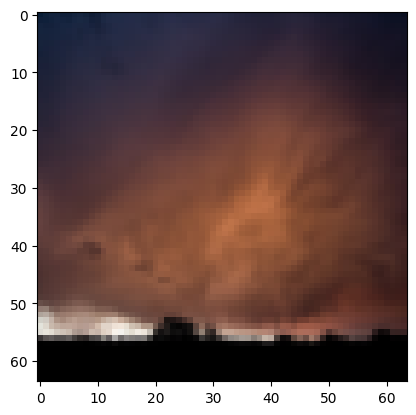

In [51]:
plt.imshow(xtrain[208])

In [52]:
np.shape(xtrain[0])

(64, 64, 3)

In [53]:
np.reshape(xtrain[0], 64*64*3)

array([17, 31, 56, ...,  0,  0,  0], shape=(12288,), dtype=uint8)

In [54]:
xtrain_= np.reshape(xtrain,(209, 64*64*3))/255
xtest_ = np.reshape(xtest,(50, 64*64*3))/255

In [55]:
len(xtrain_[208])

12288

In [56]:
64*64*3

12288

Construyamos una red neuronal con una capa de entrada, una capa de salida con una red y L-1 redes ocultas.

# Con m datos de entrenamientos.

Para $m$ datos de entrenamiento, las expresión anteriores pueden ser resumidas en las siguientes ecuaciones



\begin{equation}
\begin{bmatrix}
z_1^{(0)}  &z_1^{(1)} & .&.& .&z_1^{(m)}\\
z_2^{(0)}  &z_2^{(1)} &. &.&  .&z_2^{(m)}\\
.          & .        &. & &   &.      \\
.          & .        &  &. &   &.      \\
.          & .        &  &  & .&      \\
z_{n^{[l]}}^{(0)}&z_{n^{[l]}}^{(1)} & . & .& .& z_{n^{[l]}}^{(m)}        \\
\end{bmatrix}^{[l]}=
\begin{bmatrix}
\theta_{11} & \theta_{12} & . & .& .& \theta_{1n^{[l-1]}}\\
\theta_{21} & \theta_{22} & . & .& .& \theta_{2n^{[l-1]}}\\
. & .  & . &   & & .\\
. & .  &   & . & & .\\
. & .  &   &  & .& .\\
\theta_{n^{[l]}1} & \theta_{n^{[l]}2} & . & .& .& \theta_{n^{[l]}n^{[l-1]}}\\
\end{bmatrix}^{[l]}_{n^{[l]} \times n^{[l-1]}}
\begin{bmatrix}
a_1^{(0)}  &a_1^{(1)} & .&.& .&a_1^{(m)}\\
a_2^{(0)}  &a_2^{(1)} &. &.&  .&a_2^{(m)}\\
.          & .        &. & &   &.      \\
.          & .        &  &. &   &.      \\
.          & .        &  &  & .&      \\
a_{n^{[L-1]}}^{(0)}&a_{n^{[L-1]}}^{(1)} & . & .& .& a_{n^{[L-1]}}^{(m)}        \\
\end{bmatrix}^{[l-1]} +
\begin{bmatrix}
b_1 \\
b_2 \\
. \\
. \\
. \\
b_{n^{[l]}}\\
\end{bmatrix}^{[l]}
\end{equation}


Escrito de una formas mas compacta tenemos que:


\begin{equation}
[ \vec{Z}^{[l](0)},\vec{Z}^{[l](1)},...,\vec{Z}^{[l](m)}  ]= \Theta^{[l]} [\vec{A}^{[l-1](0)},\vec{A}^{[l-1](1)},...,\vec{A}^{[l-1](m)} ]+ \vec{b}^{[l]}
\end{equation}

Aplicando la funcion de activación:

\begin{equation}
[\vec{A}^{[l](0)},\vec{A}^{[l](1)},...,\vec{A}^{[l](m)} ]=f([\vec{Z}^{[l](0)},\vec{Z}^{[l](1)},...,\vec{Z}^{[l](m)}  ])
\end{equation}

Las dimensiones de las expresiones anteriores, pueden ser resumidas en lo siguiente:

$\mathrm{dim(\vec{\cal{Z}}^{[l]})}=n^{[l]}\times m $

$\mathrm{dim(\vec{\Theta}^{[l]})}=n^{[l]}\times n^{[l-1]}$

$\mathrm{dim(\vec{\cal{A}}^{[l]})}=n^{[l-1]}\times m $

$\mathrm{dim(\vec{b}^{[l]})}=n^{[l]}$




## Topología de la red.

1. Construir un clase  que permita definir una red neuronal con la topología
deseada y la función de activación para cada capa, para ello deberá construir una funcion Topology con el número de capas de la red neuronal :

Topology = [n_x, n_h1, n_h2, n_h3, ...,n_y]

En este caso:
- $n^{[0]}=n_x$ seran los valores de entradas de la capa de entrada
- $n^{[1]}=n_{h1}$ Primera capa oculta de la red neuronal
- $n^{[2]}=n_{h2}$ Segunda capa oculta de la red neuronal

.

.

.


- $n^{[l]}=n_{hl}$ Segunda capa oculta de la red neuronal
.

.

.

- $n^{[L]}=n_{y}$ Segunda capa oculta de la red neuronal

donde

- $\mathrm{n_x}$: valores de entrada
- $\mathrm{n_{h1}}$: hidden layer 1
- $\mathrm{n_{h2}}$: hidden layer 2
- $\mathrm{n_y}$: last layer

- $n^{[L]}=n_{y}$ Segunda capa oculta de la red neuronal


También definir una lista con las funciones de activaciones para cada capa.


activation=[None, relu, relu, relu, ...,sigmoid]

  


a. Cada unas de las capas deberá tener los parámetros de inicialización de manera aleatoria:


La matriz de parametros para cada capa debera tener:


$\mathrm{dim(\vec{b}^{[l]})}=n^{[l]}$

$\mathrm{dim(\vec{\Theta}^{[l]})}=n^{[l]}\times n^{[l-1]}$

Lo anteriores parametros deberán estar en el constructor de la clase.


b. Construya un metodo llamado output cuya salida serán los valores de Z y A


$\mathrm{dim(\vec{\cal{A}}^{[l]})}=n^{[l-1]}\times m $

$\mathrm{dim(\vec{\cal{Z}}^{[l]})}=n^{[l]}\times m $.



Se sugiere para cada capa emplear programación orientada a objetos definida de la siguiente manera:

```
class layer_nn():
  def __init__(self, act_fun, nlayer_present, nlayer_before):
    self.theta = 2*np.random.random((nlayer_present, nlayer_before)) - 1
    self.B = 2*np.random.random((nlayer_present,1)) - 1
    self.act_fun = act_fun

  def output(self, Z, A):
    self.Z = Z
    self.A = A



def act_function(x, activation):
  if activation=="sigmoid":
    f = lambda x: 1/(1+np.exp(-x))
    fp = f(x)*(1-f(x))
    return f, fp
  
  elif activation == "tanh":
    f = lambda x: np.tanh
    return tanh
  else :
    return 0
```
    

2. Construir un generalizacion de la red, en el que entrada el valor inicial
y la red neuronal completa arroje la salida y la actualizacion de la red con los parametros deseados:

  ```
  A, nn = forward_pass(A0, nn_red)

 ```
3. Encontrar la funcion de coste.


$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


4. Construir un codigo que permita realizar el BackwardPropagation


# Backward Propagation

Para una capa $l$ arbitraria tenemos que:

- \begin{equation}
d\Theta^{[l]} =  d{\cal Z}^{(i)[l]} Trans(A)^{(i)[l-1]} = dA^{(i)[l]} f'({\cal Z}^{(i)[l]} ) Trans(A)^{(i)[l-1]}
\end{equation}

- \begin{equation}
db^{[l]} =  d{\cal Z}^{(i)[L]}  = dA^{(i)[l]} f'({\cal Z}^{(i)[l]} )
\end{equation}
```
db_L =  m_*np.sum(dZ, axis=1, keepdims=True)
```
Los valores de dA pueden ser escritos como:
- \begin{equation}
dA^{(i)[l-1]} = \Theta^{l} \cdot dZ^{(i)[l]}
\end{equation}





$ dZ^{[l]} = dA^{[l]} * f'^{[l]} (Z^{[l]}) $
$ d\Theta^{[l]} = \frac{\partial \mathcal{J} }{\partial \Theta^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{1}$
$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{2}$
$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = \theta^{[l] T} dZ^{[l]} \tag{3}$


Para la capa L esima:

```
dAL = -(np.divide(Y, A) - np.divide(1 - Y, 1 - A))
```

# Aplicacion gradiente descendente

$$ \Theta^{[l]} = \Theta^{[l]} - \alpha \text{ } d\Theta^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$



Se sugiere para cada capa emplear programación orientada a objetos definida de la siguiente manera:

```python
class layer_nn():
  def __init__(self, act_fun, nlayer_present, nlayer_before):
    self.theta = 2*np.random.random((nlayer_present, nlayer_before)) - 1
    self.B = 2*np.random.random((nlayer_present,1)) - 1
    self.act_fun = act_fun

  def output(self, Z, A):
    self.Z = Z
    self.A = A

def act_function(x, activation):
  if activation=="sigmoid":
    f = lambda x: 1/(1+np.exp(-x))
    fp = f(x)*(1-f(x))
    return f, fp
  
  elif activation == "tanh":
    f = lambda x: np.tanh
    return tanh
  else :
    return 0

```

2. Construir un generalizacion de la red, en el que entrada el valor inicial y la red neuronal completa arroje la salida y la actualizacion de la red con los parametros deseados:

```python
A, nn = forward_pass(A0, nn_red)

```

3. Encontrar la funcion de coste.
$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

4. Construir un codigo que permita realizar el BackwardPropagation

# Backward Propagation

Para una capa  arbitraria tenemos que:

$$ d\Theta^{[l]} =  d\mathcal{Z}^{(i)[l]} Trans(A)^{(i)[l-1]} = dA^{(i)[l]} f'(\mathcal{Z}^{(i)[l]} ) Trans(A)^{(i)[l-1]} $$

$$ db^{[l]} =  d\mathcal{Z}^{(i)[L]}  = dA^{(i)[l]} f'(\mathcal{Z}^{(i)[l]} ) $$

```python
db_L =  m_*np.sum(dZ, axis=1, keepdims=True)

```

Los valores de dA pueden ser escritos como:

$$ dA^{(i)[l-1]} = \Theta^{l} \cdot dZ^{(i)[l]} $$

$$ dZ^{[l]} = dA^{[l]} * f'^{[l]} (Z^{[l]}) $$

$$ d\Theta^{[l]} = \frac{\partial \mathcal{J} }{\partial \Theta^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{1} $$

$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{2} $$

$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = \theta^{[l] T} dZ^{[l]} \tag{3} $$

Para la capa L esima:

```python
dAL = -(np.divide(Y, A) - np.divide(1 - Y, 1 - A))

```

# Aplicacion gradiente descendente

$$ \Theta^{[l]} = \Theta^{[l]} - \alpha \text{ } d\Theta^{[l]} \tag{16} $$

$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17} $$

```

```

Matrix([[0.927325521002059, -0.233116962348445], [0.583450076165329, 0.0577898395058090]])


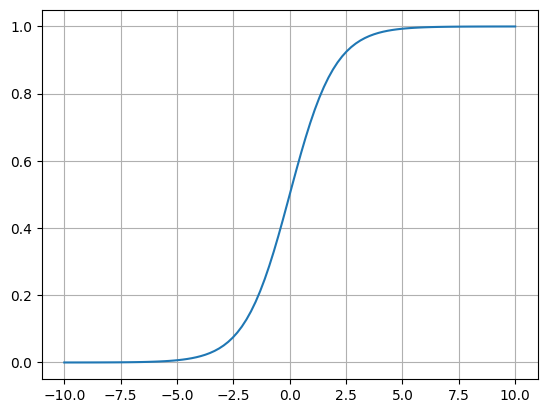

In [57]:
m = 2*np.random.random((2, 2)) - 1

print(sp.Matrix(m))

class layer_nn():
  def __init__(self, func_act, nn_present, nn_before):
    np.random.seed(42)
    self.theta = 2*np.random.random((nn_present, nn_before)) - 1
    self.b = 2*np.random.random((nn_present, 1))-1
    self.func_acti = func_act

  def output(self, A, Z):
    self.A = A
    self.Z = Z


def activation_function(name, x):
  if (name=="sigmoid"):
    f = lambda x: 1/(1+np.exp(-x))
    return f(x)

  elif (name=="tanh"):
    f =  lambda x: np.tanh(x)
    return f(x)
  else :
    return "Error"
  
x = np.linspace(-10, 10, 100)
plt.plot(x, activation_function("sigmoid", x))
plt.grid()
plt.show()

In [58]:
nx = 12288
Topology = [nx,3, 4, 7, 1 ]

In [59]:
l1 = layer_nn("sigmoid",3, nx)
l2 = layer_nn("sigmoid", 4, 3)
l3 = layer_nn("sigmoid", 7, 4)
l4 = layer_nn("sigmoid",1, 7)


In [60]:
# Incializacion de la arquitectura de la red
red_nn = [l1, l2, l3, l4]

In [61]:
# Valores iniciales
A0 = xtrain_.T

In [62]:
#np.shape(l1.theta)

In [63]:
np.shape(l1.theta@A0)

(3, 209)

In [64]:
np.shape(l1.theta@A0 )

(3, 209)

In [65]:
np.shape(l1.b.repeat(209, axis = 1))

(3, 209)

# layer 1

In [66]:
Z1 = l1.theta@A0 + l1.b
A1 = activation_function(l1.func_acti, Z1)

# layer 2

In [67]:
Z2 = l2.theta@A1 + l2.b
A2 = activation_function(l2.func_acti, Z2)

# layer 3

In [68]:
Z3 = l3.theta@A2 + l3.b
A3 = activation_function(l3.func_acti, Z3)

# layer 4

In [69]:
Z4 = l4.theta@A3 + l4.b
A4 = activation_function(l4.func_acti, Z4)

In [70]:
np.shape(A4)

(1, 209)

In [71]:
ref=A4[0].copy()

# Generalizacion Forward Pass

In [72]:
import numpy as np
import sympy as sp
class layer_nn():
  def __init__(self, func_act, nn_present, nn_before):
    np.random.seed(0)
    self.theta = 2*np.random.random((nn_present, nn_before)) - 1
    self.b = 2*np.random.random((nn_present, 1))-1
    self.func_acti = func_act

  def output(self, A, Ap, Z):
    self.A = A
    self.Z = Z
    self.Ap = Ap

  def derivative(self,dtheta, db ):
    self.dtheta = dw
    self.db = db

def activation_function(name, x):
  if (name=="sigmoid"):
    f = lambda x: 1/(1+np.exp(-x))
    return f(x), f(x)

  elif (name=="tanh"):
    f =  lambda x: np.tanh(x)
    return f(x)
  else :
    return "Error"


In [73]:
nx = 12288
Topology = [nx,3, 4, 7, 1 ]
act_func = ["sigmoid","sigmoid", "sigmoid", "sigmoid", "sigmoid"]

In [74]:
def build_red(Topology, act_func):
  L = len(Topology)
  red_nn=[]
  for i in range(1, L):
    li = layer_nn(act_func[i], Topology[i], Topology[i-1] )
    red_nn.append(li)
  return red_nn

In [75]:
nx = 12288
Topology = [nx,3, 4, 7, 1 ]
act_func = ["sigmoid","sigmoid", "sigmoid", "sigmoid", "sigmoid"]
nn = build_red(Topology, act_func)


\begin{equation}
[ \vec{Z}^{[l](0)},\vec{Z}^{[l](1)},...,\vec{Z}^{[l](m)}  ]= \Theta^{[l]} [\vec{A}^{[l-1](0)},\vec{A}^{[l-1](1)},...,\vec{A}^{[l-1](m)} ]+ \vec{b}^{[l]}
\end{equation}


In [76]:
def forward_pass(A0, nn):
  update_nn = []
  for layer in nn:
    print(np.shape(layer.theta))
    li = layer
    Zi = li.theta@A0 + li.b
    Aii, Ap = activation_function(li.func_acti, Zi)
    li.output(Aii, Ap,Zi)
    update_nn.append(li)
    A0 = Aii.copy()

  return Aii, update_nn
#  A1 = activation_function(l1.func_acti, Z1)

In [77]:
nx = 12288
Topology = [nx,3, 4, 7, 1 ]
act_func = ["sigmoid","sigmoid", "sigmoid", "sigmoid", "sigmoid"]
nn = build_red(Topology, act_func)
AL, update_nn = forward_pass(A0, nn)

(3, 12288)
(4, 3)
(7, 4)
(1, 7)




# Backward Propagation

Para una capa $l$ arbitraria tenemos que:

- \begin{equation}
d\Theta^{[l]} =  d{\cal Z}^{(i)[l]} Trans(A)^{(i)[l-1]} = dA^{(i)[l]} f'({\cal Z}^{(i)[l]} ) Trans(A)^{(i)[l-1]}
\end{equation}

- \begin{equation}
db^{[l]} =  d{\cal Z}^{(i)[L]}  = dA^{(i)[l]} f'({\cal Z}^{(i)[l]} )
\end{equation}
```
db_L =  m_*np.sum(dZ, axis=1, keepdims=True)
```
Los valores de dA pueden ser escritos como:
- \begin{equation}
dA^{(i)[l-1]} = \Theta^{l} \cdot dZ^{(i)[l]}
\end{equation}





$ dZ^{[l]} = dA^{[l]} * f'^{[l]} (Z^{[l]}) $
$ d\Theta^{[l]} = \frac{\partial \mathcal{J} }{\partial \Theta^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{1}$
$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{2}$
$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = \theta^{[l] T} dZ^{[l]} \tag{3}$


Para la capa L esima:

```
dAL = -(np.divide(Y, A) - np.divide(1 - Y, 1 - A))
```

In [78]:
Y = np.array(train_label)

In [79]:
def cost_func(Y, A):
  m = Y.shape[0]
  ji = - ( Y*np.log(A)-(1-Y)*np.log(1-A))
  cost = ji.sum()
  return cost/m

In [80]:
J = cost_func(Y, AL)

In [81]:
m_= 1/209
dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
fp = update_nn[3].Ap
dZ = dAL*fp
dthetaL = dZ@update_nn[2].A.T
db_L =  m_*np.sum(dZ, axis=1, keepdims=True)

update_nn[3].dtheta=dthetaL
update_nn[3].db=db_L


In [82]:
np.shape(update_nn[3].theta.T)

(7, 1)

In [83]:
np.shape(dZ)

(1, 209)

In [84]:
# Capa L-1
dAL_1 = np.dot(update_nn[3].theta.T, dZ)
fp = update_nn[2].Ap
dZ_1 = dAL_1*fp

dtheta_L1 = m_*dZ_1@update_nn[1].Ap.T
db_L1 = dZ_1.mean()

update_nn[2].dtheta=dtheta_L1
update_nn[2].db=db_L1

In [85]:
# Capa L-1
dAL_1 = np.dot(update_nn[2].theta.T, dZ_1)
fp = update_nn[1].Ap
dZ_1 = dAL_1*fp

dtheta_L1 = m_*dZ_1@update_nn[0].Ap.T
db_L1 = dZ_1.mean()

update_nn[1].dtheta=dtheta_L1
update_nn[1].db=db_L1

In [86]:
# Generalizar ...